In [1]:
using DrWatson

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using PersistenceDiagrams, Pipe, Plots, ProgressMeter, Random, Ripserer, Statistics, StatsBase
using Distributions, LinearAlgebra, UMAP

In [42]:
function scale_embeddings(X)
    return StatsBase.standardize(ZScoreTransform, X, dims=1)
end

function diagram(X; dim_max)
    dgm = ripserer(X |> Alpha, dim_max=dim_max)
    [replace(x -> death(x) == Inf ? PersistenceInterval(birth(x), threshold(d)) : x, d) for d in dgm]
end

function bottleneck_distance(Dx, Dy; order=nothing, p=Inf)
    order = isnothing(order) ? 0 : order
    dx, dy = Dx[1+order], Dy[1+order]∫∫
    m = max(0, min(length.((dx, dy))...) .- 2)
    dx = dx[end-m:end]
    dy = dy[end-m:end]
    return norm(map((x, y) -> (x .- y) .|> abs |> maximum, dx, dy), p)
end

function subsample(X, a=1)
    sample(X |> rdpg.m2t, round(Int, size(X, 1)^a), replace=false)
end

function generate_graph(n; k=2, r=0.1, p=0.2)
    Z = rand(1:k, n)
    f = (x, y) -> r + p * (x == y)
    return rdpg.Adjacency(f, Z)
end

function generate_graph(n)
    Z = [0.25 .* (cos(t), sin(t)) .+ 0.5 for t in range(0, 2*pi, length=n)]
    f = (x, y) -> dot(x, y)
    return rdpg.Adjacency(f, Z)
end

function sim(n, d, e, order, p=2)
    ϵ = e

    A = generate_graph(n)
    X, _, _ = rdpg.spectralEmbed(A, d=d)
    DX = diagram(X |> subsample, dim_max=order)
    plt1 = @pipe X |> rdpg.m2t |> scatter(_, label="1", ratio=1, ma=0.1, msw=0)


    X_norm = scale_embeddings(X)
    DX_norm = diagram(X_norm |> subsample, dim_max=order)
    plt2 = @pipe X_norm |> rdpg.m2t |> scatter(_, label="1", ratio=1, ma=0.1, msw=0)


    A1 = rdpg.edgeFlip(A, ϵ=ϵ)
    X1, _ = rdpg.spectralEmbed(A1, d=d)
    X1_norm = scale_embeddings(X1)
    D1_norm = diagram(X1_norm |> subsample, dim_max=order)
    plt2 = @pipe X1 |> rdpg.m2t |> scatter(plt2, _, ratio=1, ma=0.5, msw=0)
    plt2 = @pipe X1_norm |> rdpg.m2t |> scatter(plt2, _, ratio=1, ma=0.1, msw=0)


    A2 = (A1 .- rdpg.τ(ϵ)^2) ./ rdpg.σ(ϵ)^2
    X2, _ = rdpg.spectralEmbed(A2, d=d)
    D2 = diagram(X2 |> subsample, dim_max=order)
    plt1 = @pipe X2 |> rdpg.m2t |> scatter(plt1, _, ratio=1, ma=0.5, msw=0)

    # println((:d_we, bottleneck_distance(DX, D2, p=p), :d_ne, bottleneck_distance(DX_norm, D1_norm, p=p)))

    return (
        (bottleneck_distance(DX, D2, order=order, p=p), bottleneck_distance(DX_norm, D1_norm, order=order, p=p)), 
        (plot(plt1, plt2), plot(plot(DX), plot(D2), title="we"), plot(plot(DX_norm), plot(D1_norm), title="ne"))
    )
end

sim (generic function with 2 methods)

---

In [63]:
function sim_n(n; Eps, repeats=5, ribbon=true, scale=:none)
    μ = zeros(size(Eps, 1), 2)
    σ = zeros(size(Eps, 1), 2)
    @showprogress for (eps, i) in zip(Eps, eachindex(Eps))
        # println("\n\n\nStarting with n=$n")
        Random.seed!(2022)
        tmp = [sim(n, 2, eps, 1, Inf)[1] for _ in 1:repeats]
        μ[i, :] = @pipe tmp |> rdpg.t2m |> mean(_, dims=1)
        σ[i, :] = @pipe tmp |> rdpg.t2m |> std( (ribbon ? 0.25 : 1e-10) .* _, dims=1)
    end

    plt = plot(Eps, x -> 0, 
        la=0, ma=0, #yscale=scale,
        label="n=$n", xlabel="ϵ", ylabel="Bottleneck distance", 
        size=(400, 300),
    )
    plt = plot(plt, Eps, μ[:, 1], ribbon = σ[:, 1], m=:o, label="ϵ known")
    plt = plot(plt, Eps, μ[:, 2], ribbon = σ[:, 2], m=:o, label="ϵ unknown")
    return plt
end

sim_n (generic function with 1 method)

In [72]:
Eps = [0.05:0.05:0.5...];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


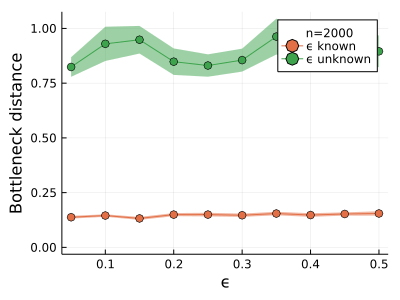

In [73]:
plt1 = sim_n(2000; Eps=Eps)

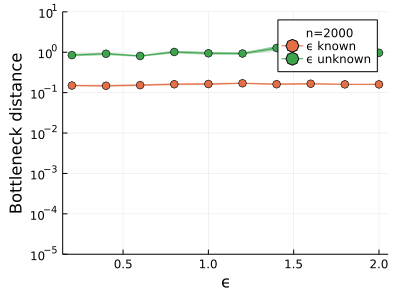

In [71]:
plot(plt1, yscale=:log10, ylim=(1e-5, 1))
plot(plt2, yscale=:log10, ylim=(1e-5, 1))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


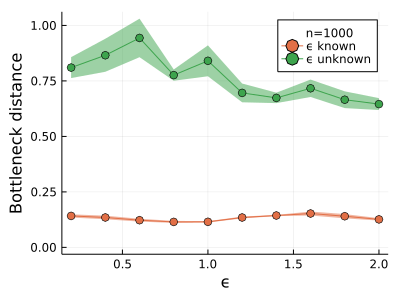

In [68]:
plt2 = sim_n(1000; Eps=Eps, ribbon=true)

----

In [83]:
function sim_Eps(eps; N, repeats=5, ribbon=true, scale=:none)
    μ = zeros(size(N, 1), 2)
    σ = zeros(size(N, 1), 2)
    @showprogress for (n, i) in zip(N, eachindex(N))
        # println("\n\n\nStarting with n=$n")
        Random.seed!(2022)
        tmp = [sim(n, 2, eps, 1, Inf)[1] for _ in 1:repeats]
        μ[i, :] = @pipe tmp |> rdpg.t2m |> mean(_, dims=1)
        σ[i, :] = @pipe tmp |> rdpg.t2m |> std( (ribbon ? 0.25 : 1e-10) .* _, dims=1)
    end

    plt = plot(N, x -> 0, 
        la=0, ma=0, #yscale=scale,
        label="eps=$eps", xlabel="ϵ", ylabel="Bottleneck distance", 
        size=(400, 300),
    )
    plt = plot(plt, N, μ[:, 1], ribbon = σ[:, 1], m=:o, label="Privacy-adjusted")
    plt = plot(plt, N, μ[:, 2], ribbon = σ[:, 2], m=:o, label="Self-normalized")
    return plt
end

sim_Eps (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:30


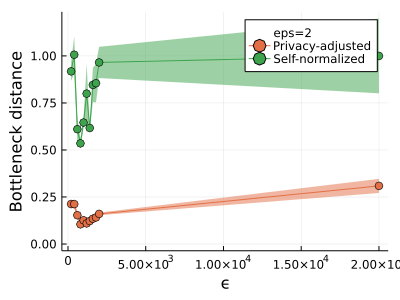

In [89]:
N = [200:200:2_000...; 20_000]
plt3 = sim_Eps(2; N=N, ribbon=true)

In [ ]:
randn(2000, 3) |> rdpg.m2t |> typeof